# Notes

- Data taken from here: https://github.com/alibashir/aav (File: allseqs_20191230.csv.zip)
- Just sequence (AA) data exists as well here: https://www.dropbox.com/sh/lmd8wmgibz24r2h/AADmgvc_0Q5mylwgGf97cTC-a/ML_and_Analysis/model_and_dataset_analysis/allseqs_20191230.csv.zip?dl=0
- [This notebook](https://github.com/churchlab/Deep_diversification_AAV/blob/main/Parsing_pipeline/Step3_compute_selection_scores.ipynb) suggest that the "target" column is `GAS1_virus_S` in the CSV file
- [This repository](https://github.com/google-research/google-research/tree/master/aav/model_training) suggest that the wild type AA sequence is 28 residues and is `DEEEIRTTNPVATEQYGSVSTNLQRGNR`
- Cutoff via gaussian mixture copied from: https://colab.research.google.com/github/google-research/google-research/blob/master/aav/model_and_dataset_analysis/data_prep.ipynb
- The UniProt sequence is here: https://www.uniprot.org/uniprot/P03135
- In UniProt notation (sequence starts at 1), the region on P03135 where the sequence mutates is `[561, 588]`

In [1]:
!pip install biopython
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

In [1]:
import pandas
import math
import random
import numpy

from pathlib import Path
from pandas import read_csv, DataFrame

from helpers import read_fasta

In [2]:
random.seed(11)

In [3]:
pandas.set_option('display.max_rows', None)

In [5]:
data_path = Path('') / '..' / 'data' / 'aav'
aav_data_path = data_path / 'allseqs_20191230.csv'

split_path = Path('') / '..' / 'splits' / 'aav'

In [29]:
aav_data = read_csv(aav_data_path)

P03135 = read_fasta(data_path / 'P03135.fasta')[0]
region = (561,588)
reference_region = "DEEEIRTTNPVATEQYGSVSTNLQRGNR"

In [30]:
aav_data.columns

Index(['sequence', 'partition', 'mutation_sequence', 'num_mutations',
       'num_edits', 'viral_selection', 'is_viable'],
      dtype='object')

In [42]:
for partition in aav_data['partition'].unique():
    print(partition)

designed
rand
single
stop
cnn_designed_plus_rand_train_walked
lr_rand_doubles_plus_single_walked
cnn_rand_doubles_plus_single_seed
cnn_standard_walked
rnn_rand_doubles_plus_singles_seed
lr_standard_walked
lr_rand_doubles_plus_single_seed
lr_designed_plus_rand_train_seed
cnn_rand_doubles_plus_single_walked
previous_chip_nonviable
cnn_designed_plus_rand_train_seed
lr_standard_seed
rnn_designed_plus_rand_train_walked
lr_designed_plus_rand_train_walked
random_doubles
rnn_standard_seed
previous_chip_viable
rnn_standard_walked
rnn_designed_plus_rand_train_seed
cnn_standard_seed
rnn_rand_doubles_plus_singles_walked
singles
wild_type


In [32]:
# Get the wild type sequence from the data

wt = aav_data[aav_data['partition'] == "wild_type"].to_dict(orient='records')[0]

In [33]:
# Make sure that all assumptions on the wild type are correct

assert(wt['sequence'] == reference_region)

# Important: region[0] -1 because UniProt notation! (0 in Python == 1 in UniProt)
assert(wt['sequence'] == str(P03135[region[0]-1 : region[1]].seq))

# Make sure chopping the sequence works as expected:

assert(
    str(P03135.seq) ==
    str(P03135[:region[0]-1].seq) + str(P03135[region[0]-1 : region[1]].seq) + str(P03135[region[1]:].seq)
)

In [34]:
# Remove data where scores are +/- inf

aav_data.replace([math.inf, -math.inf], math.nan, inplace=True)
aav_data.dropna(inplace=True)

In [57]:
# We need to aggregate synonymous variants if operating on AA sequences
# Take the score and devide by number of synonymous WT AA seuqneces!

def aggregate_rows(dataframe_slice):
    
    first_element = dataframe_slice.iloc[0]
    
    return {
        'mutation_mask': first_element.mutation_sequence,
        'mutated_region': first_element.sequence,
        'category': first_element.partition,
        'number_of_mutations': first_element.num_mutations,
        'levenshtein_distance': first_element.num_edits,
        'binary_score': first_element.is_viable,
        'score': dataframe_slice.viral_selection.mean()
    }

grouped_protein_data = aav_data.groupby(['sequence', 'partition']).apply(aggregate_rows).values

protein_data = DataFrame.from_records(grouped_protein_data)

In [58]:
def region_cut(new_sequence):
    filtered_sequence = new_sequence.upper().replace('*','')
    return str(P03135[:region[0]-1].seq) + filtered_sequence + str(P03135[region[1]:].seq)

protein_data['full_aa_sequence'] = protein_data['mutated_region'].apply(region_cut)

Based on the the manuscript:
 
> To avoid overfitting to experimental noise, rather than predicting the quantitative production efficiency we used binary classification models to predict whether each sequence variant is viable (Supplementary Fig. 1), as defined by a threshold fit to best separate positive and negative controls (WT replicas, and variants containing stop codons, respectively).

Apparently, by plotting `score` one should see a binomial. The cutoff is set somewhere beteen -2.5 and 0.

<AxesSubplot:>

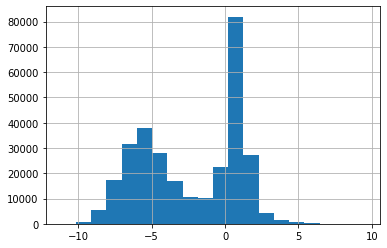

In [59]:
protein_data['score'].hist(bins=20)

In [60]:
aav_data.partition.value_counts()

designed                                56326
random_doubles                          25040
rnn_standard_walked                     20838
cnn_designed_plus_rand_train_walked     20759
rnn_designed_plus_rand_train_walked     20731
lr_standard_walked                      20456
cnn_rand_doubles_plus_single_walked     20454
cnn_standard_walked                     20395
rnn_rand_doubles_plus_singles_walked    20154
lr_rand_doubles_plus_single_walked      19999
lr_designed_plus_rand_train_walked      19680
rand                                     9857
lr_rand_doubles_plus_single_seed         2071
rnn_designed_plus_rand_train_seed        2065
rnn_rand_doubles_plus_singles_seed       2045
lr_designed_plus_rand_train_seed         2030
cnn_rand_doubles_plus_single_seed        2022
lr_standard_seed                         1989
cnn_standard_seed                        1924
rnn_standard_seed                        1916
cnn_designed_plus_rand_train_seed        1898
single                            

In [65]:
import pandas as pd

In [68]:
pd.value_counts(aav_data.query("partition == 'designed'")['num_edits'])

4     9670
3     9340
5     9153
6     8514
2     5800
7     1289
8     1215
9     1142
10    1073
11    1011
12     965
13     882
14     816
15     736
16     653
17     578
18     526
19     450
20     393
21     356
22     289
23     259
24     211
25     184
26     148
27     118
28     103
29      93
30      85
31      63
32      50
33      47
34      41
35      27
36      17
38      13
37      13
39       3
Name: num_edits, dtype: int64

In [61]:
protein_data.category.value_counts()

designed                                56326
random_doubles                          25040
rnn_standard_walked                     20838
cnn_designed_plus_rand_train_walked     20759
rnn_designed_plus_rand_train_walked     20731
lr_standard_walked                      20456
cnn_rand_doubles_plus_single_walked     20454
cnn_standard_walked                     20395
rnn_rand_doubles_plus_singles_walked    20154
lr_rand_doubles_plus_single_walked      19999
lr_designed_plus_rand_train_walked      19680
rand                                     9857
lr_rand_doubles_plus_single_seed         2071
rnn_designed_plus_rand_train_seed        2065
rnn_rand_doubles_plus_singles_seed       2045
lr_designed_plus_rand_train_seed         2030
cnn_rand_doubles_plus_single_seed        2022
lr_standard_seed                         1989
cnn_standard_seed                        1924
rnn_standard_seed                        1916
cnn_designed_plus_rand_train_seed        1898
single                            

In [62]:
design_train = [
    'previous_chip_viable',
    'previous_chip_nonviable', 
    'stop',
    'single',
    'singles',
    'wild_type',
    'random_doubles'
]

design_test = [
    'designed',
    'cnn_designed_plus_rand_train_walked',
    'lr_rand_doubles_plus_single_walked',
    'cnn_rand_doubles_plus_single_seed',
    'cnn_standard_walked',
    'rnn_rand_doubles_plus_singles_seed',
    'lr_standard_walked',
    'lr_rand_doubles_plus_single_seed',
    'lr_designed_plus_rand_train_seed',
    'cnn_rand_doubles_plus_single_walked',
    'cnn_designed_plus_rand_train_seed',
    'lr_standard_seed',
    'rnn_designed_plus_rand_train_walked',
    'lr_designed_plus_rand_train_walked',
    'rnn_standard_seed',
    'rnn_standard_walked',
    'rnn_designed_plus_rand_train_seed',
    'cnn_standard_seed',
    'rnn_rand_doubles_plus_singles_walked',
]

def design_split(category):
    if category in design_train:
        return "train"
    elif category in design_test:
        return "test"
    else:
        return "unknown"
    
def design_split_reversed(category):
    if category in design_train:
        return "test"
    elif category in design_test:
        return "train"
    else:
        return "unknown"

protein_data['design_split'] = protein_data.category.apply(design_split)
protein_data['design_split_reversed'] = protein_data.category.apply(design_split_reversed)

In [63]:
natural_allowed = [
    'previous_chip_viable',
    'previous_chip_nonviable', 
    'stop',
    'single',
    'singles',
    'wild_type',
    'random_doubles'
]

# randomly pick a few, see distribution of mutations
def natural_split_1(category):
    if category in natural_allowed:
        return random.choices(['train', 'test'], weights=[0.8, 0.2], k=1)[0]
    else:
        return "unknown"

# from train, those w/ many mutations

num_mutations_threshold = 7

test_count = len(protein_data[protein_data.number_of_mutations > num_mutations_threshold])
total = len(protein_data)

test_percentage = (test_count*100)/total

print(f'The test set will be {test_percentage}% of the data.')

def natural_split_2(row):
    if row.category in natural_allowed:
        if row.number_of_mutations > num_mutations_threshold:
            return "test"
        else:
            return "train"
    else:
        return "unknown"
    

protein_data['natural_split_1'] = protein_data.category.apply(natural_split_1)
protein_data['natural_split_2'] = protein_data.apply(natural_split_2, axis=1)

The test set will be 63.866471761155424% of the data.


In [19]:
# Random sample n sequences from train k times for single shot learning approaches

n = 96
k = 100

protein_data['natural_split_1_random_train_set'] = 'unassigned'
protein_data['natural_split_2_random_train_set'] = 'unassigned'

natural_split_1_train = protein_data.query('natural_split_1 == "train"')
natural_split_1_train_index = list(natural_split_1_train.index)

natural_split_1_kn_indexes = numpy.array(random.sample(natural_split_1_train_index, k=k*n)).reshape(k,n)

for i, kn_index in enumerate(natural_split_1_kn_indexes):
    protein_data.loc[kn_index, 'natural_split_1_random_train_set'] = f"S{i+1}"
    
natural_split_2_train = protein_data.query('natural_split_2 == "train"')
natural_split_2_train_index = list(natural_split_2_train.index)

natural_split_2_kn_indexes = numpy.array(random.sample(natural_split_2_train_index, k=k*n)).reshape(k,n)

for i, kn_index in enumerate(natural_split_2_kn_indexes):
    protein_data.loc[kn_index, 'natural_split_2_random_train_set'] = f"S{i+1}"

In [64]:
# Check how much are in test/train for each set

def get_stats(split_name):
    return f"""
    Set {split_name} has {
      len(protein_data.query(f"{split_name}=='train'"))
    } train and {
      len(protein_data.query(f"{split_name}=='test'"))
    } test sequences. {
      round(len(protein_data.query(f"{split_name}=='test' & binary_score==True")) /
      len(protein_data.query(f"{split_name}=='test'")) * 100)
    }% of test is positive.
    """

print(get_stats("design_split"))
print(get_stats("design_split_reversed"))
print(get_stats("natural_split_1"))
print(get_stats("natural_split_2"))


    Set design_task has 29287 train and 257752 test sequences. 57% of test is positive.
    

    Set design_task_reversed has 257752 train and 29287 test sequences. 23% of test is positive.
    

    Set natural_task_1 has 23466 train and 5821 test sequences. 24% of test is positive.
    

    Set natural_task_2 has 28845 train and 442 test sequences. 22% of test is positive.
    


In [21]:
# Add reference region for completeness
protein_data['reference_region'] = reference_region

protein_data[
    ['mutation_mask', 'mutated_region', 'category', 'number_of_mutations',
    'levenshtein_distance', 'score', 'full_aa_sequence', 'binary_score', 'reference_region',
    'design_split', 'design_split_reversed', 'natural_split_1', 'natural_split_2',
    'natural_split_1_random_train_set', 'natural_split_2_random_train_set']
].to_csv(split_path / "full_data.csv", index=False)

In [22]:
ml_categories = ['train','test']

# Design regression
design_split_regression = protein_data[protein_data.design_split.isin(ml_categories)]
design_split_regression = design_split_regression.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'design_split': 'set',
}, axis=1)

design_split_regression[
    ['sequence', 'target', 'set']
].to_csv(split_path / 'splits' / "design_split_regression.csv", index=False)

del design_split_regression

# Design reversed regression
design_split_reversed_regression = protein_data[protein_data.design_split_reversed.isin(ml_categories)]
design_split_reversed_regression = design_split_reversed_regression.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'design_split_reversed': 'set',
}, axis=1)

design_split_reversed_regression[
    ['sequence', 'target', 'set']
].to_csv(split_path / 'splits' / "design_split_reversed_regression.csv", index=False)

del design_split_reversed_regression

# Natural 1 regression
natural_split_1_regression = protein_data[protein_data.natural_split_1.isin(ml_categories)]
natural_split_1_regression = natural_split_1_regression.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'natural_split_1': 'set',
    'natural_split_1_random_train_set': 'random_sample'
}, axis=1)

natural_split_1_regression[
    ['sequence', 'target', 'set', 'random_sample']
].to_csv(split_path / 'splits' / "natural_split_1_regression.csv", index=False)

del natural_split_1_regression

# Natural 2 regression
natural_split_2_regression = protein_data[protein_data.natural_split_2.isin(ml_categories)]
natural_split_2_regression = natural_split_2_regression.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'natural_split_2': 'set',
    'natural_split_2_random_train_set': 'random_sample'
}, axis=1)

natural_split_2_regression[
    ['sequence', 'target', 'set', 'random_sample']
].to_csv(split_path / 'splits' / "natural_split_2_regression.csv", index=False)

del natural_split_2_regression